In [20]:
import glob
from   collections import defaultdict

import numpy  as np
import tables as tb

import matplotlib.pyplot as plt

from invisible_cities. database           import load_db             as dbf
from invisible_cities. reco               import tbl_functions as tblf
from invisible_cities. core               import system_of_units     as units
from invisible_cities. reco                    import calib_sensors_functions  as csf


from invisible_cities. evm .histos        import HistoManager
from invisible_cities. io  .pmaps_io      import load_pmaps
from invisible_cities. io  .dst_io        import load_dst
from invisible_cities. reco.tbl_functions import get_rwf_vectors

from invisible_cities. core.core_functions import to_col_vector
import matplotlib.patches as mpatches

from collections import defaultdict

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15

In [3]:
run_number  = 6075
adc_to_pes  = dbf.DataSiPM(run_number).adc_to_pes.values    .astype(np.double)
sipm_active = dbf.DataSiPM(run_number).Active.values
sipm_active[649] = 0

In [4]:
def calibrate_sipms(sipm_wfs, adc_to_pes, thr, *, bls_mode=3):
    """
    Subtracts the baseline, calibrates waveforms to pes
    and suppresses values below `thr` (in pes).
    """
#    thr  = to_col_vector(np.full(sipm_wfs.shape[0], thr))
    bls  = csf.subtract_baseline(sipm_wfs, bls_mode=bls_mode)
    cwfs = csf.calibrate_wfs(bls, adc_to_pes)
    return np.where(cwfs > thr, cwfs, 0)

In [5]:
in_path = f'/Users/ansimez/Documents/InvCit/hdf5/ZeroSuppression/*{run_number}*h5'

for in_file in glob.glob(in_path):
    with tb.open_file(in_file, "r") as h5in:
        var = defaultdict(list)
        events, _ = tblf.get_event_numbers_and_timestamps_from_file(h5in)
        nevt, pmtrwf, sipmrwf, _ = get_rwf_vectors(h5in)
        pmtrwf_full  = pmtrwf[:][events%2 >  0]
        pmtrwf_zs    = pmtrwf[:][events%2 == 0] 
        sipmrwf_full = calibrate_sipms(sipmrwf[:][events%2 >  0], adc_to_pes, 1, bls_mode=csf.BlsMode.mode)
        sipmrwf_zs   = calibrate_sipms(sipmrwf[:][events%2 == 0], adc_to_pes, 1, bls_mode=csf.BlsMode.mode)
        sipmrwfZS    = sipmrwf[:][events%2 == 0]
        odd_events   = events[events%2 >  0]
        pair_events  = events[events%2 == 0]

In [6]:
sample_init = 640
sample_end  = 680

sipmrwf_full_sel = sipmrwf_full[:, :, sample_init:sample_end]
sipmrwf_zs_sel   = sipmrwf_zs  [:, :, sample_init:sample_end]


n_full      = []
n_zs        = []
n_zs_cut    = []
n_zs_all    = []
samples     = []

charge_loss  = defaultdict(list)
total_charge = defaultdict(list)

step = 5
counter = 0
for event in odd_events:
    if event+1 not in pair_events:
        continue
    evt_full = np.where(odd_events ==event  )[0][0]
    evt_zs   = np.where(pair_events==event+1)[0][0]
        
    if not np.allclose(pmtrwf_full[evt_full], pmtrwf_zs[evt_zs]):
        continue
    counter += 1
    
    rwf_full   = csf.mask_sensors(sipmrwf_full_sel[evt_full], sipm_active)
    rwf_zs     = csf.mask_sensors(sipmrwf_zs_sel  [evt_zs  ], sipm_active)
    rwf_zs_all = csf.mask_sensors(sipmrwf_zs      [evt_zs  ], sipm_active)
    
    sel = np.sum(rwf_full, axis=1) > 5
    n_full.append(len(rwf_full[sel]))
    sel = np.sum(rwf_zs, axis=1) > 0
    n_zs.append(len(rwf_zs[sel]))
    sel = np.sum(rwf_zs, axis=1) > 5
    n_zs_cut.append(len(rwf_zs[sel]))
    
    sel = np.sum(rwf_zs_all, axis=1) > 0
    n_zs_all.append(len(rwf_zs_all[sel]))

    sel = sipmrwfZS[evt_zs] > 0
    samples.append(1 - len(sipmrwfZS[evt_zs][sel])/(1300*1792))
    
    for minE in np.arange(0, sample_end-sample_init, step):
        sel = (np.sum(rwf_full, axis=1) > 5) & (np.sum(rwf_zs, axis=1) == 0)
        charge_loss [minE].append(rwf_full[sel, minE:minE+step].sum())
        total_charge[minE].append(rwf_full[(np.sum(rwf_full, axis=1) > 5), minE:minE+step].sum())

charge_loss  = {k:np.array(v) for k,v in charge_loss .items()}
total_charge = {k:np.array(v) for k,v in total_charge.items()}

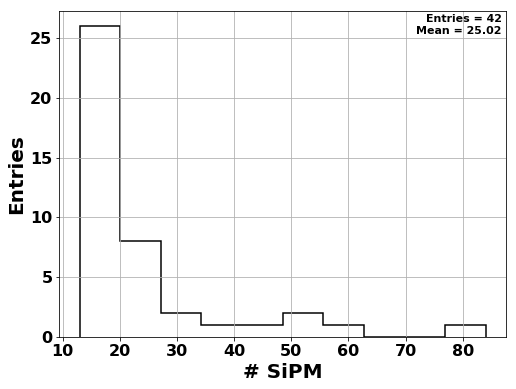

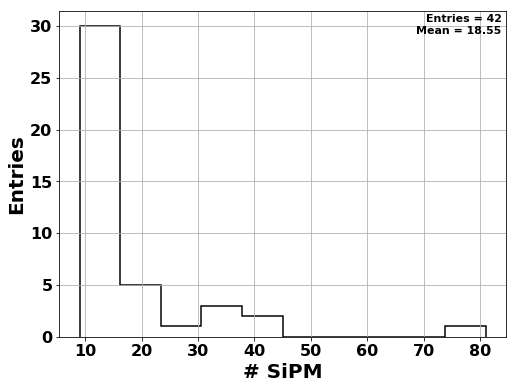

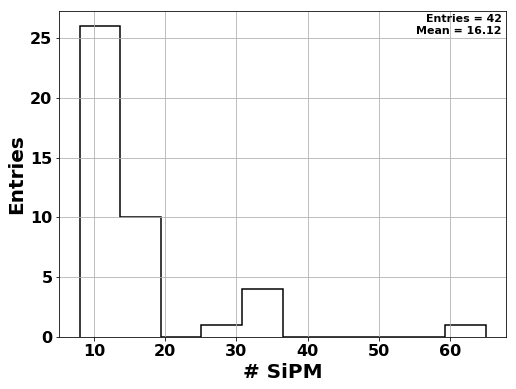

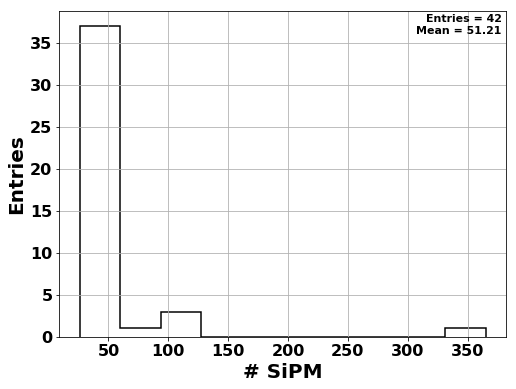

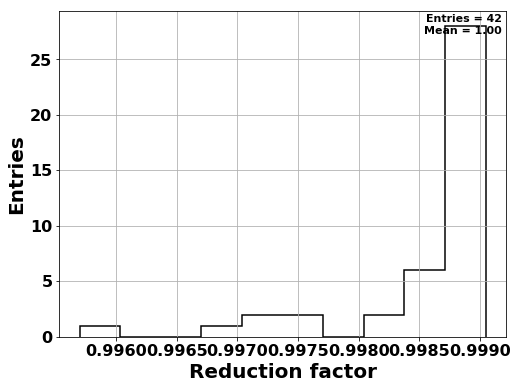

In [7]:
fig, axes = plt.subplots(1, 1)

var = n_zs_all

axes.hist(var, 10, histtype  = 'step', edgecolor = 'black', lw=1.5);
axes.grid(True)
axes.set_ylabel("Entries", weight='bold', fontsize=20)
axes.set_xlabel("# SiPM", weight='bold', fontsize=20)

for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize  (16)

entries_string = f'Entries = {len(var)}\n'
mean_string    = f'Mean = {np.mean(var):.2f}'
    
axes.annotate(entries_string + mean_string,
              xy                  = (0.99, 0.99),
              xycoords            = 'axes fraction',
              fontsize            = 11,
              weight              = 'bold',
              color               = 'black',
              horizontalalignment = 'right',
              verticalalignment   = 'top')

plt.savefig(f'/Users/ansimez/Documents/InvCit/hdf5/ZeroSuppression/R{run_number}_ZS_AllSiPM_number.pdf')





fig, axes = plt.subplots(1, 1)

var = n_zs

axes.hist(var, 10, histtype  = 'step', edgecolor = 'black', lw=1.5);
axes.grid(True)
axes.set_ylabel("Entries", weight='bold', fontsize=20)
axes.set_xlabel("# SiPM", weight='bold', fontsize=20)

for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize  (16)

entries_string = f'Entries = {len(var)}\n'
mean_string    = f'Mean = {np.mean(var):.2f}'
    
axes.annotate(entries_string + mean_string,
              xy                  = (0.99, 0.99),
              xycoords            = 'axes fraction',
              fontsize            = 11,
              weight              = 'bold',
              color               = 'black',
              horizontalalignment = 'right',
              verticalalignment   = 'top')

plt.savefig(f'/Users/ansimez/Documents/InvCit/hdf5/ZeroSuppression/R{run_number}_ZS_WindowSiPM_number.pdf')




fig, axes = plt.subplots(1, 1)

var = n_zs_cut

axes.hist(var, 10, histtype  = 'step', edgecolor = 'black', lw=1.5);
axes.grid(True)
axes.set_ylabel("Entries", weight='bold', fontsize=20)
axes.set_xlabel("# SiPM", weight='bold', fontsize=20)

for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize  (16)

entries_string = f'Entries = {len(var)}\n'
mean_string    = f'Mean = {np.mean(var):.2f}'
    
axes.annotate(entries_string + mean_string,
              xy                  = (0.99, 0.99),
              xycoords            = 'axes fraction',
              fontsize            = 11,
              weight              = 'bold',
              color               = 'black',
              horizontalalignment = 'right',
              verticalalignment   = 'top')

plt.savefig(f'/Users/ansimez/Documents/InvCit/hdf5/ZeroSuppression/R{run_number}_ZS_WindowCutSiPM_number.pdf')



fig, axes = plt.subplots(1, 1)

var = n_full

axes.hist(var, 10, histtype  = 'step', edgecolor = 'black', lw=1.5);
axes.grid(True)
axes.set_ylabel("Entries", weight='bold', fontsize=20)
axes.set_xlabel("# SiPM", weight='bold', fontsize=20)

for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize  (16)

entries_string = f'Entries = {len(var)}\n'
mean_string    = f'Mean = {np.mean(var):.2f}'
    
axes.annotate(entries_string + mean_string,
              xy                  = (0.99, 0.99),
              xycoords            = 'axes fraction',
              fontsize            = 11,
              weight              = 'bold',
              color               = 'black',
              horizontalalignment = 'right',
              verticalalignment   = 'top')

plt.savefig(f'/Users/ansimez/Documents/InvCit/hdf5/ZeroSuppression/R{run_number}_Full_WindowCutSiPM_number.pdf')

fig, axes = plt.subplots(1, 1)

var = samples

axes.hist(var, 10, histtype  = 'step', edgecolor = 'black', lw=1.5);
axes.grid(True)
axes.set_ylabel("Entries", weight='bold', fontsize=20)
axes.set_xlabel("Reduction factor", weight='bold', fontsize=20)

for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize  (16)

entries_string = f'Entries = {len(var)}\n'
mean_string    = f'Mean = {np.mean(var):.2f}'
    
axes.annotate(entries_string + mean_string,
              xy                  = (0.99, 0.99),
              xycoords            = 'axes fraction',
              fontsize            = 11,
              weight              = 'bold',
              color               = 'black',
              horizontalalignment = 'right',
              verticalalignment   = 'top')

plt.savefig(f'/Users/ansimez/Documents/InvCit/hdf5/ZeroSuppression/R{run_number}_SampleReduction.pdf')

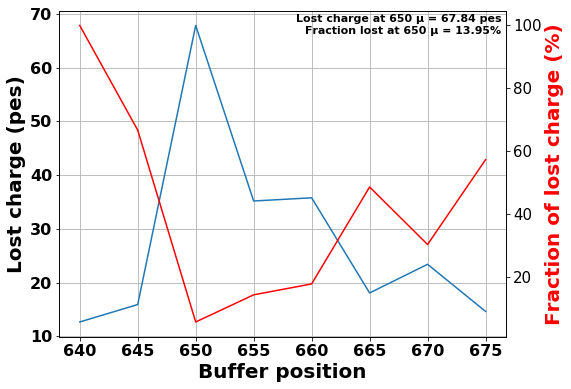

In [8]:
fig, axes = plt.subplots(1, 1)

var = n_full

axes.plot(np.array(list(charge_loss.keys())) + sample_init, np.mean(list(charge_loss.values()), axis=1))
axes.grid(True)
axes.set_ylabel("Lost charge (pes)", weight='bold', fontsize=20)
axes.set_xlabel("Buffer position", weight='bold', fontsize=20)

axes2 = axes.twinx()
axes2.plot(np.array(list(charge_loss.keys())) + sample_init, 
           100*np.mean(list(charge_loss.values()))/np.mean(list(total_charge.values()), axis=1), c='r')
axes2.set_ylabel("Fraction of lost charge (%)", weight='bold', fontsize=20 ,color='r')
#axes2.set_ylim(0., 10.)
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize  (16)

#entries_string     = f'Entries = {len(var)}\n'
#mean_string        = f'Mean = {np.mean(var):.2f}\n'

frac = 100*np.mean(list(charge_loss.values()), axis=1)[2]/np.mean(list(total_charge.values()), axis=1)[2]
fcharge = np.mean(list(charge_loss.values())[2])
fcharge_loss_string = f'Lost charge at 650 µ = {fcharge:.2f} pes\n' 
charge_loss_string = f'Fraction lost at 650 µ = {frac:.2f}%' 

axes.annotate(fcharge_loss_string + charge_loss_string,
              xy                  = (0.99, 0.99),
              xycoords            = 'axes fraction',
              fontsize            = 11,
              weight              = 'bold',
              color               = 'black',
              horizontalalignment = 'right',
              verticalalignment   = 'top')

plt.savefig(f'/Users/ansimez/Documents/InvCit/hdf5/ZeroSuppression/R{run_number}_ChargeLoss.pdf')



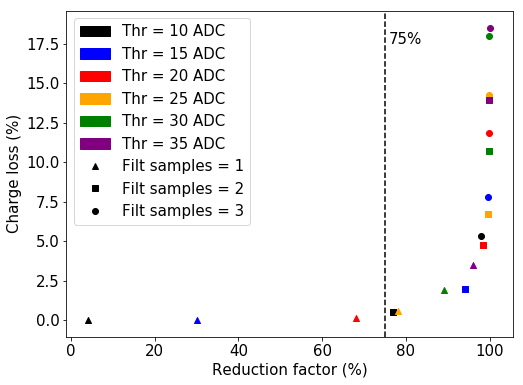

In [28]:
zs20 = np.array([68, 98.5, 99.9])
zs10 = np.array([4, 77, 98])
zs15 = np.array([30, 94, 99.7])
zs25 = np.array([78, 99.6, 99.9])
zs30 = np.array([89, 99.9, 99.94])
zs35 = np.array([96, 99.9, 99.96])

cl20 = np.array([0.14, 4.76, 11.84])
cl10 = np.array([0, 0.5, 5.29])
cl15 = np.array([0.01, 1.94, 7.78])
cl25 = np.array([0.56, 6.7, 14.26])
cl30 = np.array([1.9, 10.67, 17.97])
cl35 = np.array([3.48, 13.95, 18.46])


s = [u'^', u's', u'o']

for _s, _x, _y in zip(s, zs20, cl20):
    plt.scatter(_x, _y, marker=_s, c='red')
for _s, _x, _y in zip(s, zs10, cl10):
    plt.scatter(_x, _y, marker=_s, c='black')
for _s, _x, _y in zip(s, zs15, cl15):
    plt.scatter(_x, _y, marker=_s, c='blue')
for _s, _x, _y in zip(s, zs25, cl25):
    plt.scatter(_x, _y, marker=_s, c='orange')
for _s, _x, _y in zip(s, zs30, cl30):
    plt.scatter(_x, _y, marker=_s, c='green')
for _s, _x, _y in zip(s, zs35, cl35):
    plt.scatter(_x, _y, marker=_s, c='purple')
    
plt.xlabel("Reduction factor (%)")
plt.ylabel("Charge loss (%)")

plt.axvline(75, ls= '--',c='k')


red_patch = mpatches.Patch(color='red', label='Thr = 20 ADC')
orange_patch = mpatches.Patch(color='orange', label='Thr = 25 ADC')
blue_patch = mpatches.Patch(color='blue', label='Thr = 15 ADC')
black_patch = mpatches.Patch(color='black', label='Thr = 10 ADC')
green_patch = mpatches.Patch(color='green', label='Thr = 30 ADC')
purple_patch = mpatches.Patch(color='purple', label='Thr = 35 ADC')

filt1 = plt.Line2D((0,0),(0,0), color='k', marker='^', linestyle='', label='Filt samples = 1')
filt2 = plt.Line2D((0,0),(0,0), color='k', marker='s', linestyle='', label='Filt samples = 2')
filt3 = plt.Line2D((0,0),(0,0), color='k', marker='o', linestyle='', label='Filt samples = 3')

plt.text(76, 17.5, '75%')
plt.legend(handles=[black_patch, blue_patch, red_patch, orange_patch, green_patch, purple_patch, filt1, filt2, filt3])

plt.savefig(f'/Users/ansimez/Documents/InvCit/hdf5/ZeroSuppression/Summary.pdf')